In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [178]:
# Configs
plt.rcParams["figure.figsize"] = (15, 5)
PRODUCT = "BANANAS"
SYMBOL = "BANANAS"
START_DAY = 3
END_DAY = 4

In [179]:
def prices_files(round: int, start: int, end: int):
    return [f"../data/island-data-bottle-round-{round}/prices_round_{round}_day_{i}.csv" for i in range(start, end+1)]
def trades_files(round: int, start: int, end: int):
    return [f"../data/island-data-bottle-round-{round}/trades_round_{round}_day_{i}_nn.csv" for i in range(start, end+1)]

rd_1_price_files, rd_1_trade_files = prices_files(1, -2, -2), trades_files(1, -2, -2)
rd_2_price_files, rd_2_trade_files = prices_files(2, -1, 1), trades_files(2, -1, 1)

all_price_files = rd_1_price_files + rd_2_price_files
all_trade_files = rd_1_trade_files + rd_2_trade_files

In [180]:
def get_prices_df(product):
    prices_df = pd.concat((pd.read_csv(filename, sep=";", usecols=lambda x: x not in ["day", "profit_and_loss"], index_col=["timestamp"]) for filename in all_price_files), axis="index").query(f"product == '{product}'").reset_index(drop=True)
    prices_df.insert(0, "timestamp", prices_df.index * 100)
    prices_df.set_index("timestamp", inplace=True)
    return prices_df

def get_trades_df(symbol):
    trades_df = pd.concat((pd.read_csv(filename, sep=";", usecols=lambda x : x not in ["buyer", "seller", "currency"], index_col=["timestamp"]) for filename in all_trade_files)).query(f"symbol == '{symbol}'").reset_index(drop=True)
    trades_df.insert(0, "timestamp", trades_df.index)
    trades_df.set_index("timestamp", inplace=True)
    return trades_df

In [181]:
prices_df = get_prices_df(PRODUCT).fillna(0)
prices_df.insert(7, "bid_volume", prices_df["bid_volume_1"] + prices_df["bid_volume_2"] + prices_df["bid_volume_3"])
prices_df.insert(14, "ask_volume", - prices_df["ask_volume_1"] - prices_df["ask_volume_2"] - prices_df["ask_volume_3"])
prices_df["diff_volume"] = prices_df["bid_volume"] + prices_df["ask_volume"]
prices_df

,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,bid_volume,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,ask_volume,mid_price,diff_volume
timestamp,,,,,,,,,,,,,,,,,
0,BANANAS,4997,26,0.0,0.0,0.0,0.0,26.0,5003,26,0.0,0.0,0.0,0.0,-26.0,5000.0,0.0
100,BANANAS,4997,20,0.0,0.0,0.0,0.0,20.0,4998,1,5004.0,20.0,0.0,0.0,-21.0,4997.5,-1.0
200,BANANAS,4997,31,0.0,0.0,0.0,0.0,31.0,5004,31,0.0,0.0,0.0,0.0,-31.0,5000.5,0.0
300,BANANAS,4997,27,0.0,0.0,0.0,0.0,27.0,5004,27,0.0,0.0,0.0,0.0,-27.0,5000.5,0.0
400,BANANAS,4997,20,0.0,0.0,0.0,0.0,20.0,5002,9,5004.0,20.0,0.0,0.0,-29.0,4999.5,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999500,BANANAS,4821,25,0.0,0.0,0.0,0.0,25.0,4822,1,4827.0,25.0,0.0,0.0,-26.0,4821.5,-1.0
3999600,BANANAS,4820,24,0.0,0.0,0.0,0.0,24.0,4823,3,4827.0,24.0,0.0,0.0,-27.0,4821.5,-3.0
3999700,BANANAS,4820,30,0.0,0.0,0.0,0.0,30.0,4821,1,4825.0,7.0,4827.0,30.0,-38.0,4820.5,-8.0


In [182]:
trades_df = get_trades_df(SYMBOL)
trades_df = trades_df[trades_df['price'] != 0]
trades_df

,symbol,price,quantity
timestamp,,,
0,BANANAS,5003.0,1
1,BANANAS,4998.0,1
2,BANANAS,5000.0,4
3,BANANAS,5000.0,3
4,BANANAS,4997.0,10
...,...,...,...
11490,BANANAS,4822.0,1
11491,BANANAS,4821.0,1
11492,BANANAS,4822.0,1


In [183]:
def time_at(day_in_df: int):
    return day_in_df * 1000000

def prices_on_day(start: int, end: int):
    new_df = prices_df.loc[time_at(start) : time_at(end)].copy()
    return new_df

def trades_on_day(start: int, end: int):
    trades_per_day = int(trades_df.shape[0] / end) # number of trades per day
    return trades_df.loc[trades_per_day * start : trades_per_day * end].copy()

In [184]:
prices_df = prices_on_day(START_DAY, END_DAY)
prices_df

,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,bid_volume,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,ask_volume,mid_price,diff_volume
timestamp,,,,,,,,,,,,,,,,,
3000000,BANANAS,4871,9,4870.0,23.0,0.0,0.0,32.0,4877,23,0.0,0.0,0.0,0.0,-23.0,4874.0,9.0
3000100,BANANAS,4875,1,4871.0,4.0,4870.0,22.0,27.0,4877,22,0.0,0.0,0.0,0.0,-22.0,4876.0,5.0
3000200,BANANAS,4870,22,0.0,0.0,0.0,0.0,22.0,4876,22,0.0,0.0,0.0,0.0,-22.0,4873.0,0.0
3000300,BANANAS,4873,1,4868.0,26.0,0.0,0.0,27.0,4875,26,0.0,0.0,0.0,0.0,-26.0,4874.0,1.0
3000400,BANANAS,4870,8,4869.0,28.0,0.0,0.0,36.0,4871,5,4875.0,28.0,0.0,0.0,-33.0,4870.5,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999500,BANANAS,4821,25,0.0,0.0,0.0,0.0,25.0,4822,1,4827.0,25.0,0.0,0.0,-26.0,4821.5,-1.0
3999600,BANANAS,4820,24,0.0,0.0,0.0,0.0,24.0,4823,3,4827.0,24.0,0.0,0.0,-27.0,4821.5,-3.0
3999700,BANANAS,4820,30,0.0,0.0,0.0,0.0,30.0,4821,1,4825.0,7.0,4827.0,30.0,-38.0,4820.5,-8.0


In [185]:
trades_df = trades_on_day(START_DAY, END_DAY)

In [186]:
trades_df.describe()

,price,quantity
count,2874.000000,2874.000000
mean,4833.210856,2.881698
std,25.460467,3.805385
min,4799.000000,0.000000
25%,4811.000000,1.000000
50%,4822.000000,1.000000
75%,4857.000000,2.000000
max,4893.000000,20.000000


<Axes: xlabel='timestamp'>

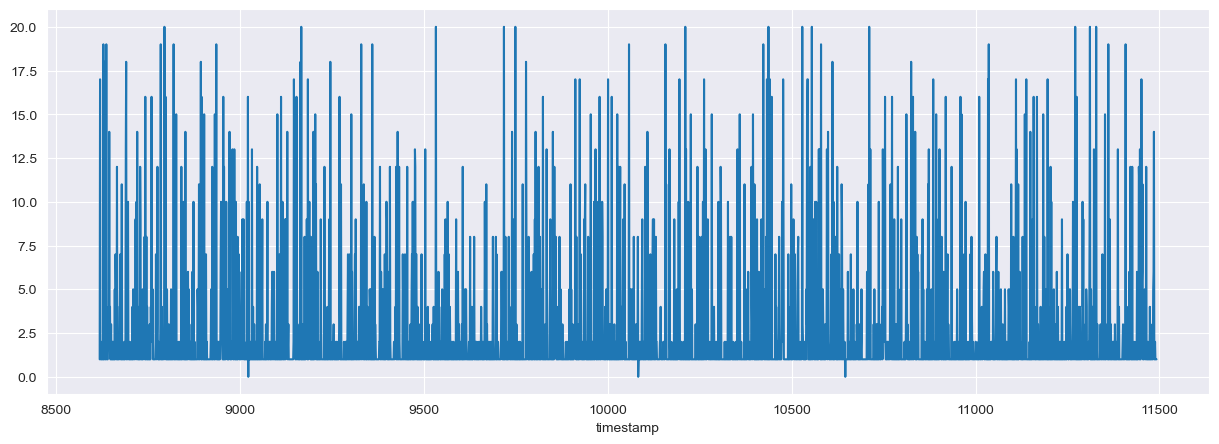

In [187]:
trades_df["quantity"].plot()

<Axes: xlabel='timestamp'>

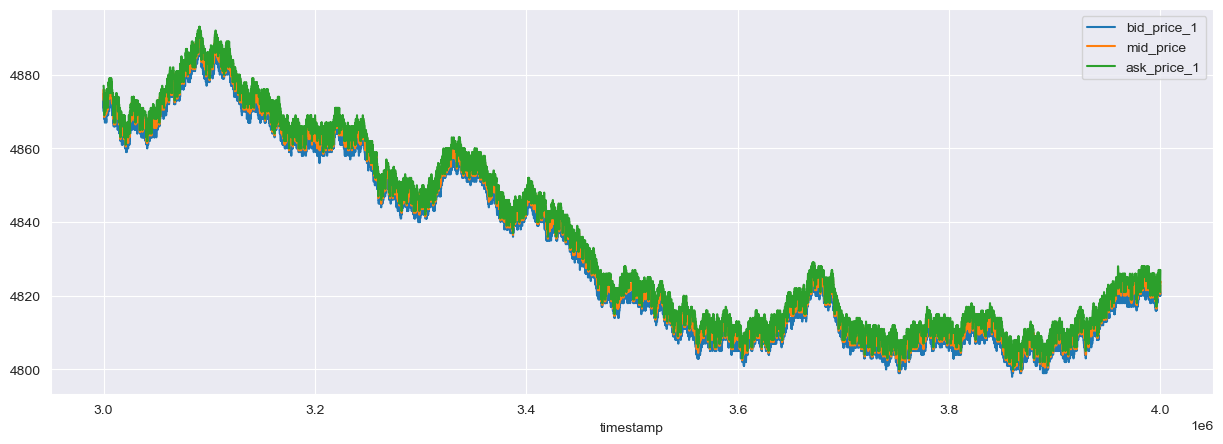

In [188]:
prices_df[["bid_price_1", "mid_price", "ask_price_1"]].plot()

<Axes: xlabel='timestamp'>

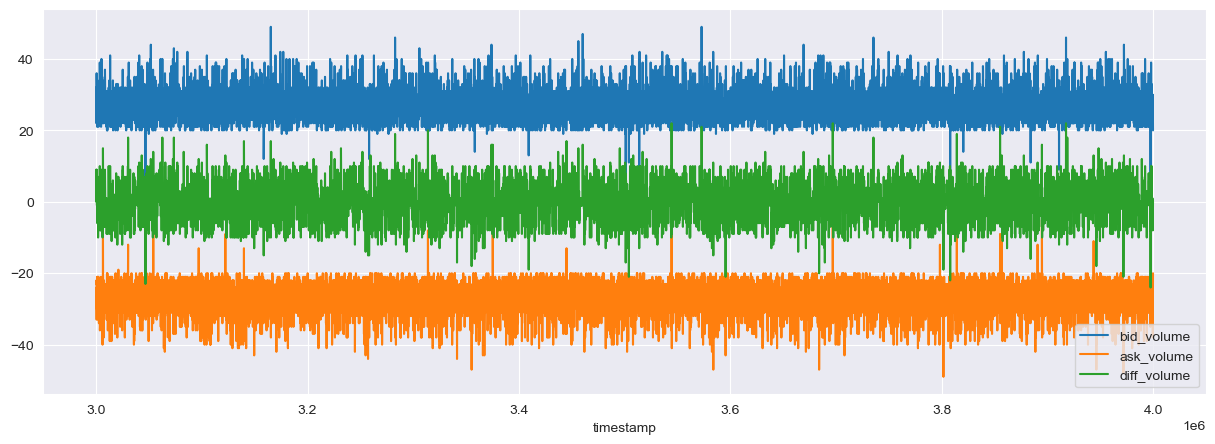

In [189]:
volumes = prices_df[["bid_volume", "ask_volume", "diff_volume"]]
volumes.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

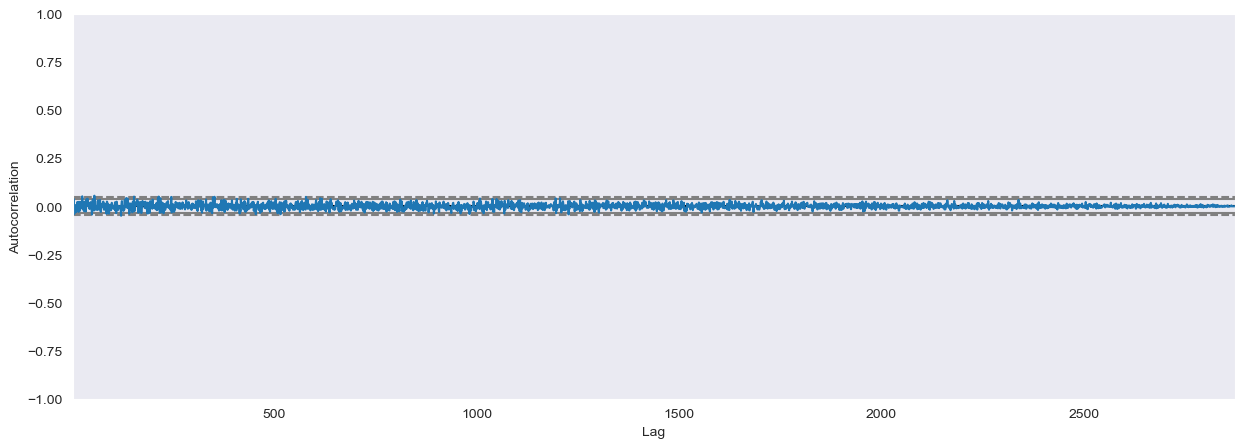

In [190]:
# Used to check randomness. If it's flat then it's random, otherwise 95% or 99% not.
pd.plotting.autocorrelation_plot(trades_df["quantity"])

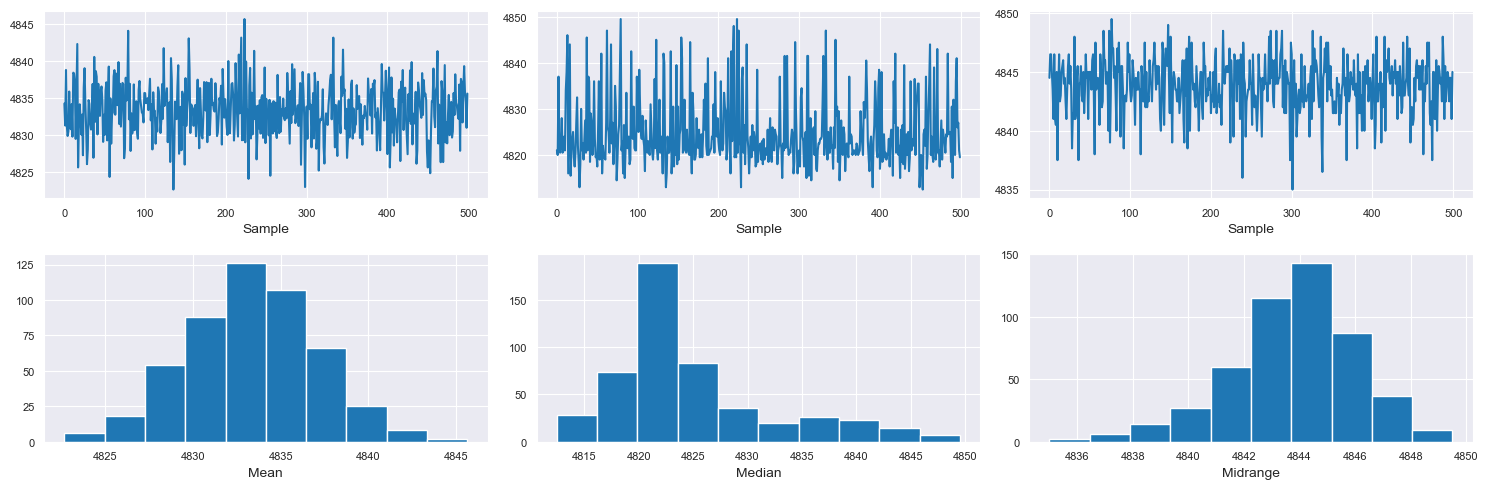

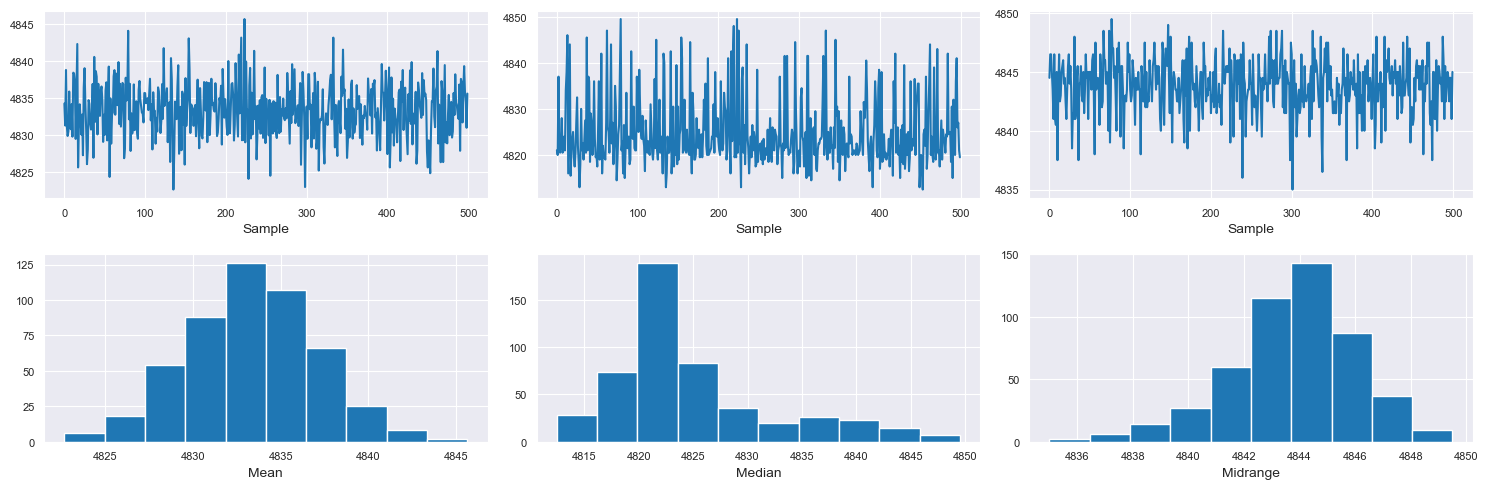

In [191]:
pd.plotting.bootstrap_plot(trades_df["price"])

In [192]:
import scipy.stats

In [193]:
def calculate_starting_price_bidask(day: int):
    result = scipy.stats.linregress(prices_df.index, prices_df["mid_price"])
    print(result)
    return result.slope * (day * 1000000)  + result.intercept

def calculate_starting_price_matched(day: int):
    result = scipy.stats.linregress(trades_df.index, trades_df["price"])
    print(result)
    return result.slope * int(trades_df.shape[0] / END_DAY) * day + result.intercept

calculate_starting_price_bidask(END_DAY), calculate_starting_price_matched(END_DAY)

LinregressResult(slope=-8.054198258541985e-05, intercept=5116.551411949839, rvalue=-0.9031066820922025, pvalue=0.0, stderr=3.830056449185193e-07, intercept_stderr=1.3450525345629825)
LinregressResult(slope=-0.027466648780397954, intercept=5109.401742761187, rvalue=-0.8951812872520812, pvalue=0.0, stderr=0.0002551803636241141, intercept_stderr=2.5746851847022723)


(4794.38348160816, 5030.517527463884)

In [194]:
prices_df["mid_price"]

timestamp
3000000    4874.0
3000100    4876.0
3000200    4873.0
3000300    4874.0
3000400    4870.5
            ...  
3999500    4821.5
3999600    4821.5
3999700    4820.5
3999800    4824.0
3999900    4823.5
Name: mid_price, Length: 10000, dtype: float64